## Import libraries and split into individual dataframes for each permutation of variables

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
df = pd.read_csv('test_1.csv')
dfs = np.array_split(df, len(df)/df.dd_span.head(1).iloc[0])

## Compile data about capture-emergence difference and clean instances with no first generation captures and/or first generation emergences

In [2]:
first_capture_data = []
for frame in dfs:
    first_capture = frame[frame.captured > 1].head(1).dd
    first_emergence = frame[(frame.pop_active_0 > 1)].head(1).dd
    if not first_capture.empty and not first_emergence.empty:
        diff = first_capture.iloc[0] - first_emergence.iloc[0]
        pop_0 = frame.head(1).pop_0.iloc[0]
        prob_capture = frame.head(1).prob_capture.iloc[0]
        mating_delay = frame.head(1).mating_delay.iloc[0]
        ratio = pop_0 * prob_capture
        first_capture_data.append((diff, ratio, pop_0, prob_capture, mating_delay))

## Organize data into three dataframes, a unified frame, an explanitory varaible frame, and a dependent variable frame

In [3]:
capture_df = pd.DataFrame(first_capture_data, columns=['difference', 'ratio', 'pop_0', 'prob_capture', 'mating_delay'])
df_x = capture_df.drop('difference', axis=1)
df_x = sm.add_constant(df_x)
df_y = capture_df['difference']

## View variables against each other

<Axes: xlabel='mating_delay', ylabel='difference'>

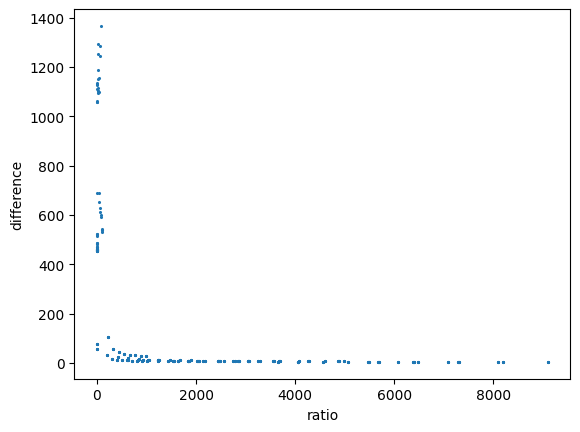

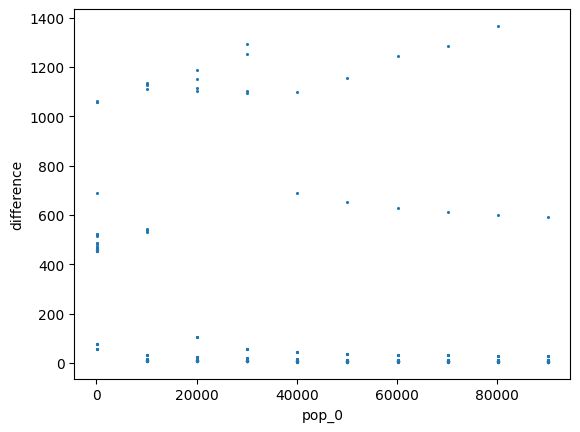

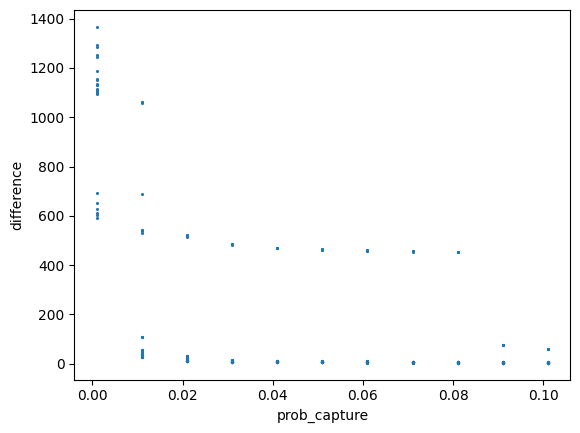

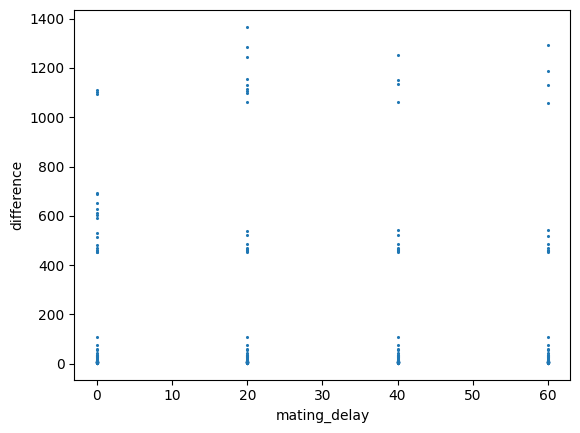

In [8]:
capture_df.plot.scatter(1, 0, 1.5, logy=False)
capture_df.plot.scatter(2, 0, 1.5, logy=False)
capture_df.plot.scatter(3, 0, 1.5, logy=False)
capture_df.plot.scatter(4, 0, 1.5, logy=False)

## The pop_0/prob_detection ratio seems promising, view in log scale to emphasize shape of the graph

<Axes: xlabel='ratio', ylabel='difference'>

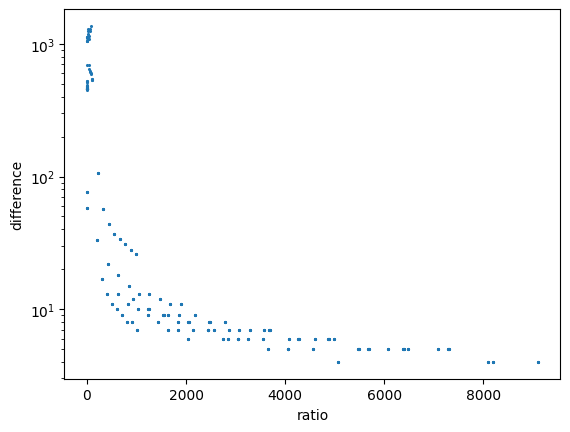

In [9]:
capture_df.plot.scatter(1, 0, 1.5, logy=True)